In [532]:
#importing libraries

import numpy as np
from scipy.optimize import fsolve
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000) 


In [533]:
#shape functions
def shapes(i):
    shape = None
    if i == 0:
        shape = lambda xi: 2*(xi - 0.5)*(xi - 1.0)
    elif i == 1:
        shape = lambda xi: -4*(xi)*(xi - 1.0)
    elif i == 2:
        shape = lambda xi: 2*(xi)*(xi - 0.5)
    return shape

#derivative of shape functions
def dershape1(xi):
    return 4*xi-3

def dershape2(xi):
    return  -8*xi + 4

def dershape3(xi):
    return 4*xi - 1

def dershapes(i):
    dershape = None
    if i == 0:
        dershape = dershape1
    elif i == 1:
        dershape = dershape2
    elif i ==2:
        dershape = dershape3
    return dershape

In [534]:
#problem function f
def f():
    fun = lambda x: x**3
    return fun

In [535]:
#partition
def genpartition(h, a=0, b=1):
    part = np.linspace(a,b,h)
    return part

#generate element from partition
def genelement(partition):
    Mi = len(partition)                    
    elements = np.ndarray.transpose(np.array([partition[:-1],partition[1:]])) #set of elements
    elementsize = partition[1:]-partition[:-1]  #element sizes
    Mk = Mi-1 #number of elememnts

    return elements

#Simpsons rule 
def integral_from_sr(element, func1, func2):
    product = lambda x: func1(x)*func2(x)
    integralgrid = np.linspace(element[0],element[1], 7)
    length = 1/18
    integral = length * (product(integralgrid[0]) + 4*product(integralgrid[1]) + 2*product(integralgrid[2]) + 4*product(integralgrid[3]) + 2*product(integralgrid[4]) + 4*product(integralgrid[5]) + product(integralgrid[6]))
    return integral

#transformation from reference to physical element
def ref_to_element(element, xi):
    return element[0] + (element[1] - element[0])*xi

#local to global transformation
def loc2glob(k,alpha):
    return k*2 +alpha

#reference stiffness matrix
def localAKhat():
    refelement = np.array([0,1])
    locA = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            locA[i,j] += integral_from_sr(refelement, dershapes(i), dershapes(j))
    return locA

#local stiffness matrix
def localAKk(element,AKhat):
    length = element[1]-element[0]
    return (1/length) * AKhat

#reference load vector
def localBKhat():
    refelement = np.array([0,1])
    locB = np.zeros(3)
    for i in range(3):
        locB[i] += integral_from_sr(refelement, f(), shapes(i))
    return locB

#local load vector
def localBKk(element, BKhat):
    length = element[1]-element[0]
    return length*BKhat

#global load vector
def localBKkglobalf(element):
    length = element[1]-element[0]
    ftoref = lambda x: f()(element[0]+ length*x)
    refelement = np.array([0,1])
    locB = np.zeros(3)
    for i in range(3):
        locB[i] += integral_from_sr(refelement, ftoref, shapes(i))
    return length*locB

#assembel gloval stiffness matrix and load vector
def assemble(elements):
    numberofele = np.shape(elements)[0]
    numberofnodes = numberofele*2 + 1
    
    locAK = localAKhat()
    #locBK = localBKhat()
    A = np.zeros((numberofnodes,numberofnodes))
    b = np.zeros(numberofnodes)

    for k in range(0,numberofele):
        Ak = localAKk(elements[k],locAK)
        bk = localBKkglobalf(elements[k])
        for alpha in range(3):
            i = loc2glob(k,alpha)
            b[i] += bk[alpha]
            for beta in range(3):
                j = loc2glob(k,beta)
                A[i,j] += Ak[alpha,beta]
    return A, b

#impose Dirichlet boundary conditions
def imposeboundary(A,b):
    A[0,:] = 0
    #A[:,0] = 0
    A[0,0] = 1
    b[0] = 0
    A[-1,:] = 0
    #A[:,-1] = 0
    A[-1,-1] = 1
    b[-1] = 0
    return A,b


0

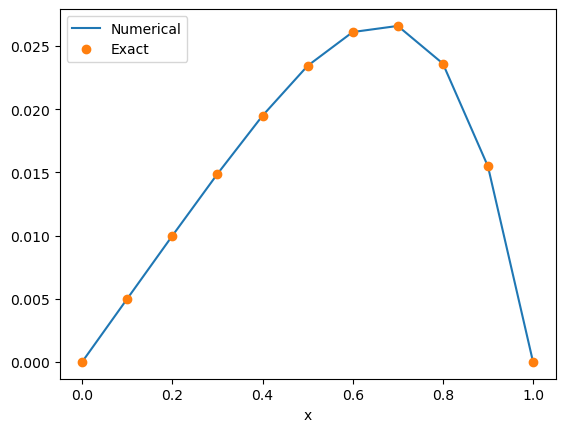

In [536]:
def main():
    partition = genpartition(11,0,1)
    elements = genelement(partition)
    A,b = assemble(elements)
    A,b = imposeboundary(A,b)
    U = np.linalg.solve(A,b)
    Uongrid = U[::2]

    # (1/6)*partition*(1-partition**2)    this is for f=x^2
    plt.plot(partition,Uongrid, partition,(1/20)*partition*(1 - partition**4),'o')
    plt.legend(['Numerical','Exact'])
    plt.xlabel('x')

    return 0

main()

### Convergence


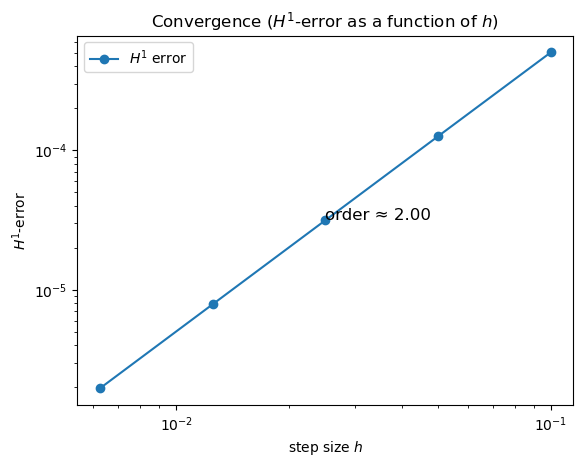

In [ ]:
def exact_u(x):
    return (1/20)*x*(1 - x**4)

def exact_u_der(x):
    return (1/20)-(1/4*x**4)

#L2 error 
def compute_L2_error(elements, U, exact_func):

    error2 = 0.0
    #define quadrature points for Simpson
    xi_points = np.linspace(0, 1, 7)
    weights = np.array([1, 4, 2, 4, 2, 4, 1]) / 18.0  

    #loop over all elements
    for k, element in enumerate(elements):
        jac = element[1] - element[0]  #Jacobian
        for xi, w in zip(xi_points, weights):
            x_phys = ref_to_element(element, xi)    
            u_ex = exact_func(x_phys)  
            uh_val = 0.0
            
            #evaluate FEM solution on the element using the shape functions
            for i in range(3):
                global_idx = loc2glob(k, i)
                uh_val += U[global_idx] * shapes(i)(xi)
                
            #add contribution to the error
            error2 += w * (u_ex - uh_val)**2 * jac
    return np.sqrt(error2)

#H1 error
def compute_H1_error(elements, U, exact_func, exact_func_der):
    error2 = 0.0       #for the L2 part of the error
    grad_error2 = 0.0  #for the H1 seminorm 
    #define quadrature points and weights for Simpsons rule 
    xi_points = np.linspace(0, 1, 7)
    weights = np.array([1, 4, 2, 4, 2, 4, 1]) / 18.0  

    #loop over all elements
    for k, element in enumerate(elements):
        jac = element[1] - element[0]  #Jacobian
        for xi, w in zip(xi_points, weights):
            x_phys = ref_to_element(element, xi)
            
            #evaluate the exact solution and its derivative at the physical
            u_ex = exact_func(x_phys)
            u_ex_der = exact_func_der(x_phys)
            
            #evaluate the finite element solution at physical
            uh_val = 0.0
            for i in range(3):
                global_idx = loc2glob(k, i)
                uh_val += U[global_idx] * shapes(i)(xi)
                
            #evaluate the finite element solution derivative
            uh_der_val = 0.0
            for i in range(3):
                global_idx = loc2glob(k, i)
                uh_der_val += U[global_idx] * dershapes(i)(xi)
                
            uh_der_val /= jac

            #add up the error and gradient error using quadrature:
            error2 += w * (u_ex - uh_val)**2 * jac
            grad_error2 += w * (u_ex_der - uh_der_val)**2 * jac

    return np.sqrt(error2 + grad_error2)


def convergence_test():
    #list of numbers of nodes for different grid refinements
    ns = [11, 21, 41, 81, 161]
    hs = []
    errors = []
    
    for n in ns:
        partition = genpartition(n, 0, 1)
        elements = genelement(partition)
        A, b = assemble(elements)
        A, b = imposeboundary(A, b)
        U = np.linalg.solve(A, b)
        
        h = partition[1] - partition[0]
        hs.append(h)
        
        #compute the error
        #err = compute_L2_error(elements, U, exact_u)     if one wants to compute L2 error
        err = compute_H1_error(elements, U, exact_u, exact_u_der)
        errors.append(err)
    
    #plot the convergence in a log-log plot. just change H^1 to L^2 to make the other plot
    plt.figure()
    plt.loglog(hs, errors, 'o-', label='$H^1$ error')
    plt.xlabel('step size $h$')
    plt.ylabel('$H^1$-error')
    plt.title('Convergence ($H^1$-error as a function of $h$)')
    
    #fit a line in log-log scale to estimate the slope
    p = np.polyfit(np.log(hs), np.log(errors), 1)
    slope = p[0]
    plt.text(hs[len(hs)//2], errors[len(errors)//2], f'order ≈ {slope:.2f}', fontsize=12)
    
    plt.legend()
    plt.show()

convergence_test()


## Optimization

In [538]:
#build system
def genelementnsize(partition):
    Mi = len(partition)    
    elements = np.ndarray.transpose(np.array([partition[:-1],partition[1:]])) #set of elements/triangulation
    elementsize = partition[1:]-partition[:-1]               #element sizes
    Mk = Mi-1 #number of elememnts

    return elements, elementsize

#B on refeerence element
def BonRef():
    refelement = np.array([0,1])
    locB = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            locB[i,j] += integral_from_sr(refelement, dershapes(i), dershapes(j))
    return locB

#F on reference element
def FonRef():
    refelement = np.array([0,1])
    locF = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            locF[i,j] += integral_from_sr(refelement, shapes(i), shapes(j))
    return locF

#desired profile boundaries on refernce element
def yd_boundariesOnRef():
    refelement = np.array([0,1])
    b_left = np.zeros(3)
    
    for i in range(2):
        b_left[i+1] += integral_from_sr(refelement,shapes(0),shapes(i+1))
    b_right = b_left[::-1]
    return b_left, b_right

#impose boundary condition on the system 
def imposeboundaryMatrixOnly(A):
    # Impose boundary condition
    # Dirichlet boundary conditions
    A[0,:] = 0
    A[0,0] = 1
    A[-1,:] = 0
    A[-1,-1] = 1
    return A

In [539]:
#assemble global stiffness matrix and load matrix
def assemble2(elements,size,ydleft, ydright):
    numberofele = np.shape(elements)[0]
    numberofnodes = numberofele*2 + 1
    
    locF = FonRef()
    locB = BonRef()
    F = np.zeros((numberofnodes,numberofnodes))
    B = np.zeros((numberofnodes,numberofnodes))

    b_left, b_right = yd_boundariesOnRef()
    b_vec = np.zeros(numberofnodes)
    b_vec[:len(b_left)] += size[0]*ydleft*b_left
    b_vec[-len(b_right):] += size[-1]*ydright*b_right

    for k in range(0,numberofele):
        Ftransformed = (size[k])*locF
        Btransformed = (1/size[k])*locB
        for alpha in range(3):
            i = loc2glob(k,alpha)
            for beta in range(3):
                j = loc2glob(k,beta)
                F[i,j] += Ftransformed[alpha,beta]
                B[i,j] += Btransformed[alpha,beta]
    
    return F, B, b_vec

#assemble system
def systemassemble(y_d, alpha, elements, size):
    Finter, Binter, b_vec = assemble2(elements, size, y_d[0], y_d[-1])

    rhs_top = Finter @ y_d + b_vec
    rhs_top[0] = 0
    rhs_top[-1] = 0
    rhs = np.zeros(len(b_vec)*3)
    rhs[:len(b_vec)] += rhs_top

    zeroblock = np.zeros_like(Finter)
    F = imposeboundaryMatrixOnly(Finter)
    B = imposeboundaryMatrixOnly(Binter)

    lhs = np.block([[F,zeroblock,-B],[zeroblock, alpha*F, F],[B, -F, zeroblock]])

    return lhs, rhs


Error: 9.246906682394345


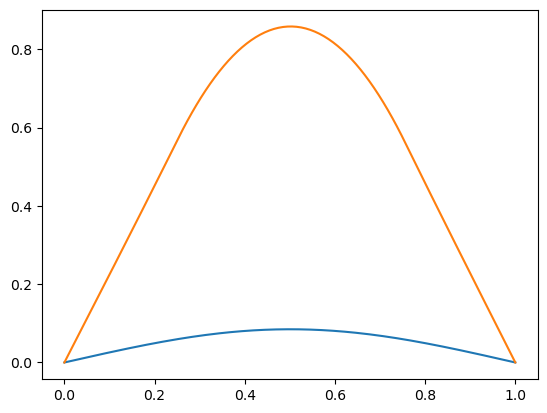

Error: 3.2511556913708497


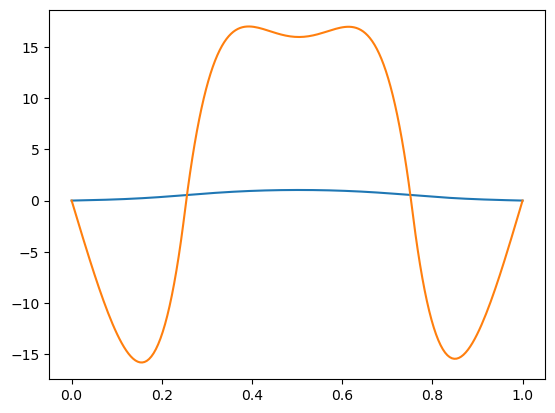

Error: 1.3605568402461057


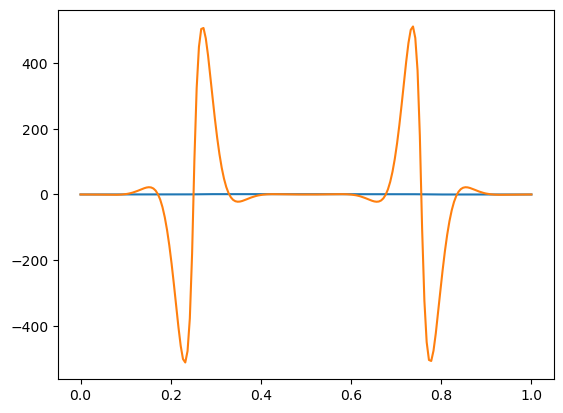

0

In [540]:
def main2():
    partition = genpartition(100,0,1)
    elements, elementsize = genelementnsize(partition)
    
    gridsize = np.shape(elements)[0]*2+1
    grid = genpartition(gridsize,0,1)

    
    #yd = 1/2x(1-x)
    #y_d = 0.5*grid*(1-grid)
    
    #yd = 1
    #y_d = np.ones(gridsize)
    
    #yd = 0, and 1 for x={1/4, 3/4} 
    y_d = np.zeros(gridsize)
    for i in range (50,150):
        y_d[i] = 1
        
        
    alphavals = [1e-1, 1e-4, 1e-7]
    
    for alpha in alphavals:
        A,b = systemassemble(y_d,alpha, elements, elementsize)
        csc_A = csc_matrix(A)
        U = spsolve(csc_A,b)
        
        y_h = U[:gridsize]
        u_h = U[gridsize:gridsize*2]
        
        print("Error: " + str(np.linalg.norm(y_h-y_d, ord=2)))

        plt.plot(grid,y_h)
        plt.plot(grid,u_h)
        
        plt.show()


    return 0

main2()